In [1]:
import os
import re
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper import save_obj, load_obj
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from glob import glob
import csv

%matplotlib inline

## Utils

In [2]:
def get_rot_tra(rot_adr, tra_adr):
    """
    Helper function to the read the rotation and translation file
        Args:
                rot_adr (str): path to the file containing rotation of an object
        tra_adr (str): path to the file containing translation of an object
        Returns:
                rigid transformation (np array): rotation and translation matrix combined
    """

    rot_matrix = np.loadtxt(rot_adr, skiprows=1)
    trans_matrix = np.loadtxt(tra_adr, skiprows=1)
    trans_matrix = np.reshape(trans_matrix, (3, 1))
    rigid_transformation = np.append(rot_matrix, trans_matrix, axis=1)

    return rigid_transformation


def fill_holes(idmask, umask, vmask):
    """
    Helper function to fill the holes in id , u and vmasks
        Args:
                idmask (np.array): id mask whose holes you want to fill
        umask (np.array): u mask whose holes you want to fill
        vmask (np.array): v mask whose holes you want to fill
        Returns:
                filled_id_mask (np array): id mask with holes filled
        filled_u_mask (np array): u mask with holes filled
        filled_id_mask (np array): v mask with holes filled
    """
    idmask = np.array(idmask, dtype='float32')
    umask = np.array(umask, dtype='float32')
    vmask = np.array(vmask, dtype='float32')
    thr, im_th = cv2.threshold(idmask, 0, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    res = cv2.morphologyEx(im_th, cv2.MORPH_OPEN, kernel)
    im_th = cv2.bitwise_not(im_th)
    des = cv2.bitwise_not(res)
    mask = np.array(des-im_th, dtype='uint8')
    filled_id_mask = cv2.inpaint(idmask, mask, 5, cv2.INPAINT_TELEA)
    filled_u_mask = cv2.inpaint(umask, mask, 5, cv2.INPAINT_TELEA)
    filled_v_mask = cv2.inpaint(vmask, mask, 5, cv2.INPAINT_TELEA)
    
    return filled_id_mask, filled_u_mask, filled_v_mask

## Camera Parameters

In [3]:
fx = 2240
px = 1024
fy = 2240
py = 1024

intrinsic_matrix = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

camera_rigid_transformation = np.array([[ -1.40374862e-02,   1.90827698e-01,  -9.81523216e-01,
          7.21728683e-01],
       [  9.98345613e-01,   5.74154668e-02,  -3.11536249e-03,
          5.66383934e+00],
       [ -5.57601154e-02,   9.79943097e-01,   1.91317961e-01,
          2.16625595e+01]])

## Load Image and Annotation 

In [4]:
num = 0

image_list = glob("C:/Users/IVCL/Desktop/crane/image/*.png")
image = plt.imread(image_list[num])

pose_list = []
f = open("C:/Users/IVCL/Desktop/crane/quat_blender.csv", "r")
lines = csv.reader(f)
for line in lines:
    pose_list.append(line)
f.close()
pose = [pose_list[num][1], pose_list[num][2], pose_list[num][3], pose_list[num][0]]
#pose = [0.48234459459881135, -0.31269724806723564, 0.22677658898359365, 0.7848336843776975]
#pose = [pose[1], pose[2], pose[3], pose[0]]
ptc_rot_matrix = R.from_quat(pose).as_dcm()
ptc_rot_matrix = np.append(ptc_rot_matrix, [[0, 0, 0]], axis=0)
ptc_trans_matrix = [[0.0],[0.0],[0.0],[1.0]]
#ptc_trans_matrix = [ 0.37825479,  2.37005807, 11.57247727]
#ptc_trans_matrix = [[ptc_trans_matrix[1]], [ptc_trans_matrix[2]], [ptc_trans_matrix[0]], [1.0]]
ptc_rigid_transformation = np.append(ptc_rot_matrix, ptc_trans_matrix, axis=1)

x_size = int(image.shape[1])
y_size = int(image.shape[0])
ID_mask = np.zeros((y_size, x_size))
U_mask = np.zeros((y_size, x_size))
V_mask = np.zeros((y_size, x_size))

## Load Point Cloud

In [5]:
pt_cld = o3d.io.read_point_cloud("crane.ply")
#pt_cld = pt_cld.voxel_down_sample(voxel_size=0.1)
pt_cld_data = np.asarray(pt_cld.points)
ones = np.ones((pt_cld_data.shape[0], 1))
homogenous_coordinate = np.append(pt_cld_data[:, :3], ones, axis=1)
print("num_points:",len(pt_cld_data))

num_points: 3836340


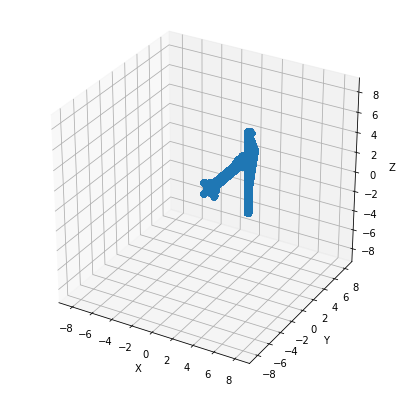

In [90]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)
ax.set_zlim(-9,9)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter(pt_cld_data[:,0],pt_cld_data[:,1],pt_cld_data[:,2])
plt.show()

## Project 2D

In [6]:
homogenous_2D = intrinsic_matrix @ (
        camera_rigid_transformation @ (ptc_rigid_transformation @ homogenous_coordinate.T))
coord_2D = homogenous_2D[:2, :] / homogenous_2D[2, :]
coord_2D = ((np.floor(coord_2D)).T).astype(int)
x_2d = np.clip(coord_2D[:, 0], 0, x_size-1)
y_2d = np.clip(coord_2D[:, 1], 0, y_size-1)
ID_mask[y_2d, x_2d] = 255

In [7]:
centre = np.mean(pt_cld_data, axis=0)
length = np.sqrt((centre[0]-pt_cld_data[:, 0])**2 + (centre[1] -
                                                     pt_cld_data[:, 1])**2 + (centre[2]-pt_cld_data[:, 2])**2)
unit_vector = [(pt_cld_data[:, 0]-centre[0])/length, (pt_cld_data[:,
                                                                  1]-centre[1])/length, (pt_cld_data[:, 2]-centre[2])/length]
U = 0.5 + (np.arctan2(unit_vector[2], unit_vector[0])/(2*np.pi))
V = 0.5 - (np.arcsin(unit_vector[1])/np.pi)
U_mask[y_2d, x_2d] = U
V_mask[y_2d, x_2d] = V

ID_mask, U_mask, V_mask = fill_holes(ID_mask, U_mask, V_mask)

ID_mask, U_mask, V_mask = np.flip(ID_mask, axis=1), np.flip(U_mask, axis=1), np.flip(V_mask, axis=1)

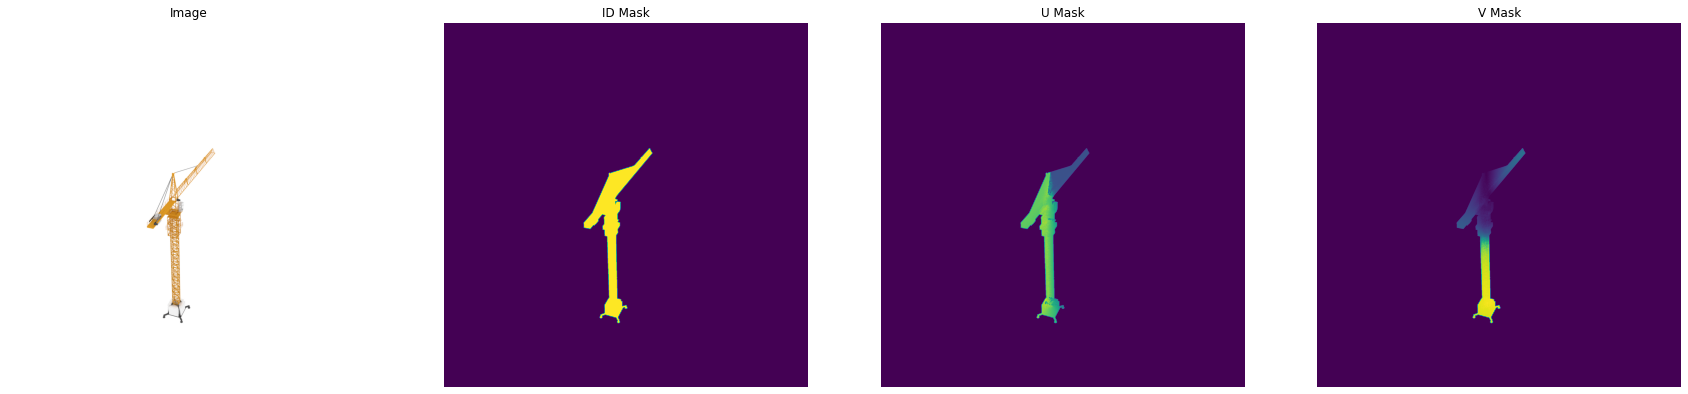

In [8]:
plt.figure(figsize=(30,30))

plt.subplot(1,4,1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(ID_mask)
plt.title("ID Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(U_mask*255)
plt.title("U Mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(V_mask*255)
plt.title("V Mask")
plt.axis("off")

plt.show()

In [10]:
cv2.imwrite("./IDmask.png",ID_mask)
cv2.imwrite("./Umask.png",U_mask*255)
cv2.imwrite("./Vmask.png",V_mask*255)

True